In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", None)
plt.rcParams.update({'figure.figsize': (15, 12)})

In [2]:
data_dir = os.path.join(os.pardir, "docs", "assets", "data")
observed_counts_path = os.path.join(data_dir, "site_data.csv")
run_date = "2020-10-02"

In [3]:
def read_csv(pth):
    df = pd.read_csv(pth).rename(columns=str.lower)
    df.date = pd.to_datetime(df.date, format="%Y-%m-%d")
    return df    

In [4]:
class case_keys:
    raw = "cases_new"
    smoothed = "cases_new_smoothed"

case_type = case_keys.smoothed


raw_counts = read_csv(observed_counts_path)

assert (raw_counts.groupby('area')
        .apply(lambda x: len(x.country.unique()))
        .unique() == 1), "Same area name in different countries"

raw_counts.drop(['country'], axis=1, inplace=True)
counts = raw_counts[['date', 'area', case_type]]

all_projections = read_csv(os.path.join(data_dir, run_date, "Cproj.csv"))
all_predictions = read_csv(os.path.join(data_dir, run_date, "Cpred.csv"))

In [5]:
class Sample:
    def __init__(self, percentiles, truth, pred_key="c_50"):
        self._dates = pd.Index.intersection(percentiles.index, truth.index)
        self.percentiles = percentiles.reindex(index=self._dates)
        self.predictions = self.percentiles[pred_key]
        self.truth = truth.reindex(index=self._dates)
        

def group_samples(counts, preds, index, by, return_missing=False):
    grouped_counts = counts.set_index(index).groupby(by)
    grouped_preds = preds.set_index(index).groupby(by)
    all_samples = dict()
    missing_from_predictions = list()
    for k, truth in grouped_counts: 
        try:
            pred = grouped_preds.get_group(k)
        except KeyError:
            missing_from_predictions.append(k)
            continue
        else:
            all_samples[k] = Sample(
                pred.drop([by], axis=1),
                truth.drop([by], axis=1).squeeze()
            )
    out = (all_samples, missing_from_predictions) if return_missing else all_samples
    return out

In [6]:
### Maybe some of the relative things should be std top over std bottom?

def _rel(predictions, truth):
    return predictions / (truth + 0.1 * np.std(truth) + 1e-2) - 1

def rmse(predictions, truth):
    return np.sqrt(np.mean(np.power(predictions - truth, 2)))

def std_err(predictions, truth):
    return np.std(predictions - truth, ddof=1)

def mae(predictions, truth):
    return np.mean(np.abs(predictions - truth))

def mad_err(predictions, truth):
    err = predictions - truth
    return np.mean(np.abs(err - mae(predictions, truth)))

def rel_mae(predictions, truth):
    return np.mean(np.abs(_rel(predictions, truth)))

def mad_rel_err(predictions, truth):
    rel = _rel(predictions, truth)
    return np.mean(np.abs(rel - rel_mae(predictions, truth)))

def rel_rmse(predictions, truth):
    return np.sqrt(np.mean(np.power(_rel(predictions, truth), 2)))

def std_rel_err(predictions, truth):
    return np.std(_rel(predictions, truth), ddof=1)

def success_codes(predictions, truth):
    """
    Return an integer from {0, 1, 2} depending on how successful the prediction
    was. If true case counts lie within 25% CI of median then return 0,
    if not this but within 47.5% CI of median then return 1, else return 2.
    """
    codify = {"c_025": 2, "c_25": 1, "c_50": 0, "c_75": 0, "c_975": 1}
    return self.percentiles.le(self.truth, axis=0).idxmin(axis=1).map(codify)

In [7]:
def _apply(metric, samples): # can change metrics later if need to get a different thing from them
    return pd.Series({k: metric(s.predictions, s.truth) for k, s in samples.items()})

def apply(m_dict, samples):
    return pd.concat({k: _apply(m, samples) for k, m in m_dict.items()}, axis=1)

## Statistics by area

In [8]:
area_in_sample = group_samples(counts, all_predictions, index='date', by='area', return_missing=False)
area_out_sample = group_samples(counts, all_projections, index='date', by='area', return_missing=False)

In [9]:
m_dict = {
    'RMSE': rmse,
    'Rel RMSE': rel_rmse,
    'MAE': mae,
    'Rel MAE': rel_mae
}

is_area_stats = apply(m_dict, area_in_sample)
oos_area_stats = apply(m_dict, area_out_sample)

area_stats = pd.concat({"In Sample": is_area_stats, "Out of Sample": oos_area_stats}, axis=1)
area_stats

In Sample                                 \
                                          RMSE  Rel RMSE        MAE   Rel MAE   
Adur                                  0.261014  0.464230   0.170068  0.327767   
Allerdale                             0.398783  0.296675   0.276190  0.238265   
Amber Valley                          0.966575  0.486980   0.610612  0.380431   
Arun                                  0.499498  0.347376   0.300544  0.280708   
Ashfield                              0.890487  0.398514   0.560816  0.306571   
Ashford                               0.678412  0.278830   0.504626  0.240065   
Ayrshire and Arran                    1.188523  0.307457   0.666939  0.254117   
Babergh                               0.211046  1.208006   0.172517  0.671520   
Barking and Dagenham                  1.458469  0.290988   0.918095  0.242144   
Barnet                                1.212335  0.215792   0.787755  0.171681   
Barnsley                              2.248836  0.274791   1.773878  0.225141   
Barrow-in-Furness                     0.551713  0.522483   0.309796  0.433660   
Basildon                              0.661708  0.233549   0.459864  0.189606   
Basingstoke and Deane                 0.308254  0.475255   0.210340  0.299448   
Bassetlaw                             0.992568  0.401772   0.714966  0.288221   
Bath and North East Somerset          0.792245  0.383970   0.527483  0.333494   
Bedford                               1.369371  0.225938   1.008707  0.191598   
Bexley                                1.173198  0.244502   0.666667  0.196383   
Birmingham                           31.673722  0.343032  17.870068  0.300069   
Blaby                                 1.081266  0.298400   0.783265  0.235209   
Blackburn with Darwen                 4.353835  0.210752   2.944218  0.172437   
Blackpool                             1.033416  0.290451   0.665850  0.257682   
Blaenau Gwent                         2.450843  0.608424   1.022721  0.559525   
Bolsover                              0.629115  0.362262   0.413605  0.313912   
Bolton                               12.067919  0.359645   6.401905  0.317731   
Borders                               0.606925  0.564497   0.305850  0.477794   
Boston                                0.321022  0.653663   0.222313  0.404214   
Bournemouth, Christchurch and Poole   1.234849  0.348861   0.722041  0.304147   
Bracknell Forest                      0.446820  0.398965   0.300000  0.262647   
Bradford                             10.424844  0.161183   7.338095  0.130471   
Braintree                             1.015356  0.344016   0.537007  0.277576   
Breckland                             0.710143  0.314168   0.362993  0.280999   
Brent                                 1.101210  0.214975   0.856190  0.181158   
Brentwood                             0.547772  0.299163   0.329524  0.237168   
Bridgend                              1.947108  0.491950   0.822721  0.448687   
Brighton and Hove                     1.110860  0.249334   0.696599  0.207437   
Bristol, City of                      1.756166  0.255756   1.094422  0.211398   
Broadland                             0.506348  0.463397   0.315918  0.327411   
Bromley                               0.806166  0.241361   0.493469  0.199420   
Bromsgrove                            0.618704  0.417006   0.456054  0.264967   
Broxbourne                            0.658462  0.305145   0.403946  0.260771   
Broxtowe                              0.772182  0.283573   0.413605  0.245592   
Buckinghamshire                       1.169870  0.179832   0.876327  0.148763   
Burnley                               1.826778  0.262732   1.059184  0.226135   
Bury                                  5.357819  0.309116   3.071020  0.274645   
Caerphilly                            4.635559  0.608928   2.040816  0.562768   
Calderdale                            2.403145  0.221656   1.694422  0.179067   
Cambridge                             0.440348  0.301713   0.332109 

## Statisics across time

In [10]:
dates_in_sample = group_samples(counts, all_predictions, index='area', by='date', return_missing=False)
dates_out_sample = group_samples(counts, all_projections, index='area', by='date', return_missing=False)

In [11]:
m_dict = {
    'centre': rel_mae,
    'dispersion': mad_rel_err
}
is_dates_rel_mae = apply(m_dict, dates_in_sample)
os_dates_rel_mae = apply(m_dict, dates_out_sample)

m_dict = {
    'centre': mae,
    'dispersion': mad_err
}
is_dates_mae = apply(m_dict, dates_in_sample)
os_dates_mae = apply(m_dict, dates_out_sample)

m_dict = {
    'centre': rel_rmse,
    'dispersion': std_rel_err
}
is_dates_rel_rmse = apply(m_dict, dates_in_sample)
os_dates_rel_rmse = apply(m_dict, dates_out_sample)

m_dict = {
    'centre': rmse,
    'dispersion': std_err
}
is_dates_rmse = apply(m_dict, dates_in_sample)
os_dates_rmse = apply(m_dict, dates_out_sample)

In [34]:
grades = range(1, 2)
def uncertainty_plot(ax, sample, color, grades=grades):
    sample.centre.plot(ax=ax, color=color)
    for perc in grades:
        ax.fill_between(
            sample.index,
            y1=sample.centre - perc * sample.dispersion,
            y2=sample.centre + perc * sample.dispersion,
            color=color,
            alpha=0.15 / perc,
            label=f"{perc}$\Delta$"
        )
    ax.grid(True, alpha=0.1)

Really the uncertainty for the RMSE shouldn't go below 0 and for relative rmse below -1...

In [35]:
c_is = "C0"
c_oos = "C3"
d = 0.05

def region_text(ax, d):
    ax.text(d, d, s="In sample", color=c_is, transform=ax.transAxes);
    ax.text(1 - d, d, s="Out of sample", color=c_oos, transform=ax.transAxes, ha="right");

def shade_info(ax, info, d):
    ax.text(
        s=info,
        x=d,
        y=1 - d,
        transform=ax.transAxes,
        va="top"
    )

## Metrics

Define the absolute and relative errors for local authority $i$ at time $t$ as
\begin{align*}
    \epsilon^i_t &= \text{predictions}^i_t - \text{truth}^i_t \\ 
    \rho^i_t &= \frac{\text{predictions}^i_t}{(1 + 0.1\text{std}(\text{truth}^i))\text{truth}^i_t + 0.01}
\end{align*}
where the std term denotes the standard deviation across time for true time series in local authority $i$.

Assume there are $L$ local authorities. 
Let $\mu$ and $\sigma$ be functions that take the sample mean and (unbiased) sample standard deviation of a time series across local authorities, then for any time $t$ we define
- RMSE as $\sqrt{\frac1L \sum_{i=1}^L (\epsilon^i_t)^2}$
- Rel RMSE as $\sqrt{\frac1L \sum_{i=1}^T (\rho^i_t)^2}$
- MAE as $\frac1L \sum_{i=1}^L |\epsilon^i_t|$
- Rel MAE as $\frac1L \sum_{i=1}^L |\rho^i_t|$
- Uncertainty for RMSE as $\sigma(\epsilon_t)$
- Uncertainty for Rel RMSE as $\sigma(\rho_t)$
- Uncertainty for MAE as $\frac1L \sum_{i=1}^L |\epsilon_t^i - \text{MAE}_t|$
- Uncertainty for Rel MAE as $\frac1L \sum_{i=1}^L |\rho_t^i - \text{Rel_MAE}_t|$

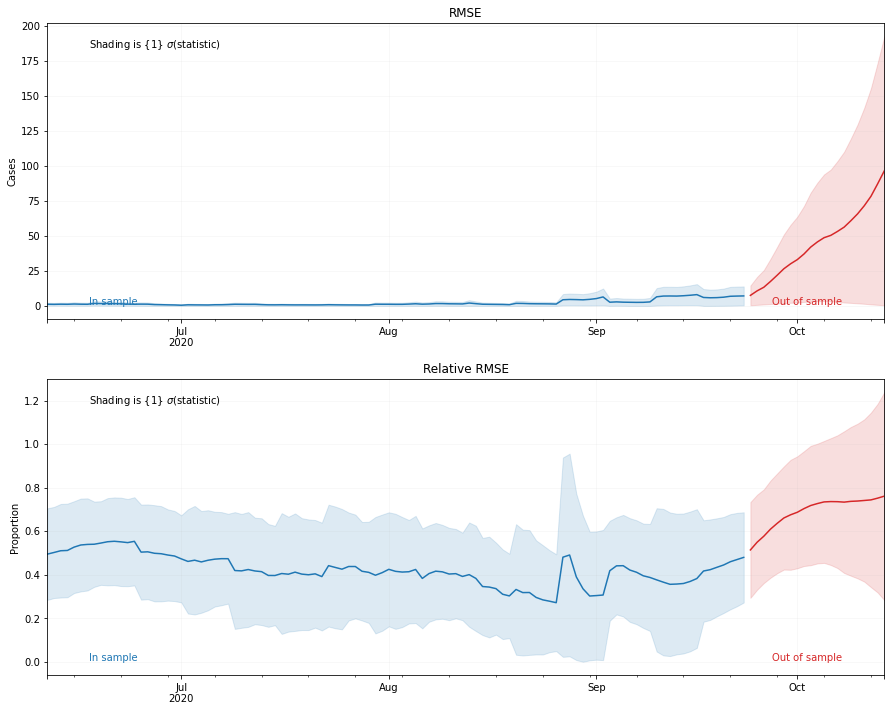

In [36]:
fig, (ax0, ax1) = plt.subplots(2, 1)    
uncertainty_plot(ax0, is_dates_rmse, c_is)
uncertainty_plot(ax0, os_dates_rmse, c_oos)
uncertainty_plot(ax1, is_dates_rel_rmse, c_is)
uncertainty_plot(ax1, os_dates_rel_rmse, c_oos)

ax0.set_title("RMSE")
ax0.set_ylabel("Cases")

ax1.set_title("Relative RMSE")
ax1.set_ylabel("Proportion");

info = f"Shading is {{{', '.join(map(str, grades))}}} $\sigma$(statistic)"
for ax in (ax0, ax1):
    region_text(ax, d)
    if grades:
        shade_info(ax, info, d)

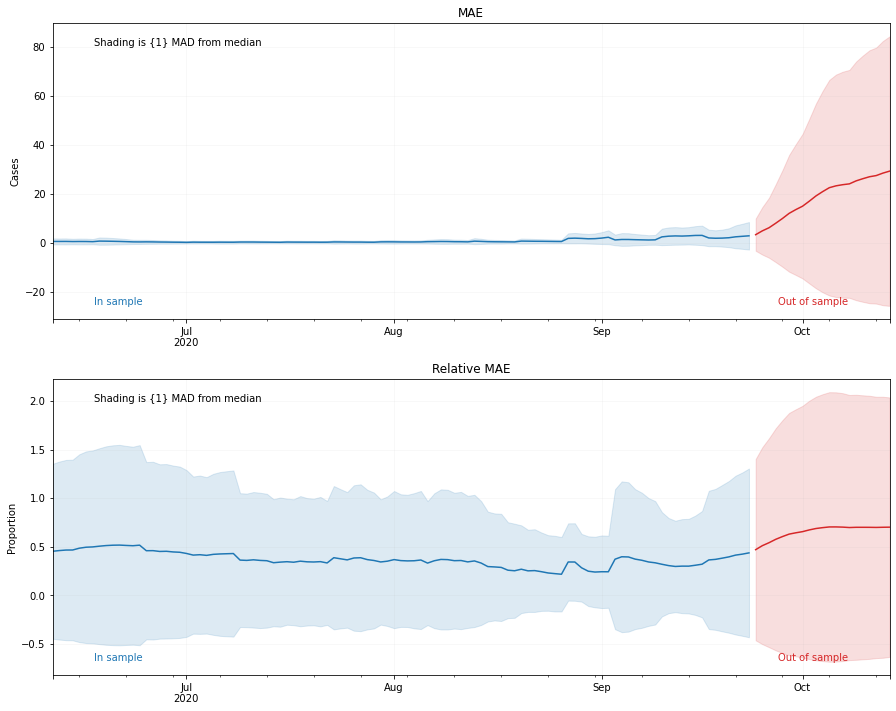

In [37]:
fig, (ax0, ax1) = plt.subplots(2, 1)    
uncertainty_plot(ax0, is_dates_mae, "C0")
uncertainty_plot(ax0, os_dates_mae, "C3")
uncertainty_plot(ax1, is_dates_rel_mae, "C0")
uncertainty_plot(ax1, os_dates_rel_mae, "C3")

ax0.set_title("MAE")
ax0.set_ylabel("Cases")

ax1.set_title("Relative MAE")
ax1.set_ylabel("Proportion")

info = f"Shading is {{{', '.join(map(str, grades))}}} MAD from median"
for ax in (ax0, ax1):
    region_text(ax, d)
    if grades:
        shade_info(ax, info, d)